In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model

In [2]:
# Get training property info

filename = 'Data/train_2016.csv'
trainid_df = pd.read_csv(filename)

# Get property info

filename = 'Data/properties_2016.csv'
properties_df = pd.read_csv(filename)

C:\Users\Matthew\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Put respective properties_df info into train_df.

properties_df.set_index('parcelid', inplace = True)
trainid_df.set_index('parcelid', inplace = True)

train_df = trainid_df.join(properties_df)

In [4]:
# Try diffusing when propertylandusetypeid is 261.0 and when it is not.

vals_df = train_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]
vals_df = vals_df.dropna()

vals_df['abslogerror'] = np.abs(vals_df.logerror.values)

In [53]:
# Define simple gradient descent for linear fit.

def l1linearfit(X, y, niterations, rate):
    npoints, nvars = X.shape
    coefficients = np.zeros(nvars)
    for i in range(niterations):
        grad = np.zeros(X.shape)
        ypredict = np.dot(X, coefficients.T)
        error = ypredict - y
        
        # Get grad update matrix
        # First the positive ones
        grad[error >= 0] = X[error >= 0]
        grad[error < 0] = -1 * X[error < 0]
        
        grad = np.sum(grad, axis = 0)
        coefficients -= grad * rate
        
    return coefficients

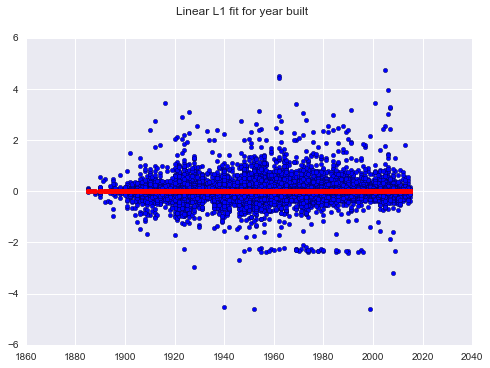

0.067578007794066863

In [63]:
# Let's get a benchmark of using just yearbuilt by looking at linear fit minimizing the L1 norm.

X = vals_df.yearbuilt.values.reshape(-1,1)
npoints, nvars = X.shape
X = np.hstack((X, np.full((npoints, 1), 1.0)))

y = vals_df.logerror.values

coeffs = l1linearfit(X, y, 50, 10**-13)
ypredict = np.dot(X, coeffs.T)

plt.scatter(vals_df.yearbuilt, y)
plt.scatter(vals_df.yearbuilt, ypredict, color = 'red')
plt.suptitle('Linear L1 fit for year built')
plt.show()

abserror = np.abs(ypredict - y)
abserror = np.mean(abserror)
abserror

In [64]:
# Let's benchmark the percentage change in original error. That is, assuming the Zillow model is correct.

origerror = np.abs(vals_df.logerror)
origerror = np.mean(origerror)

(abserror - origerror) / origerror

-0.0047201299480441796

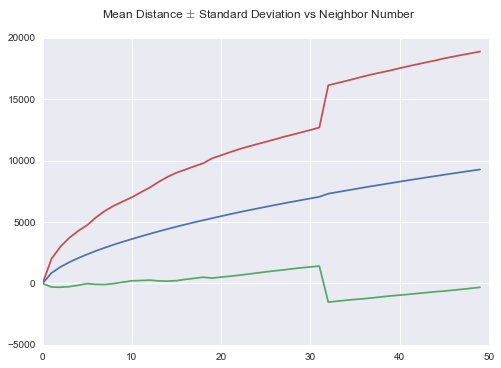

In [19]:
# Get an idea of how large the distances are for up to 20 neighbors
nbrs = NearestNeighbors(50)
nbrs.fit(vals_df[['latitude', 'longitude']])
points = vals_df[['latitude', 'longitude']]
distances, indices = nbrs.kneighbors(points)
meandist = np.mean(distances, axis = 0)
stddist = np.std(distances, axis = 0)

plt.plot(meandist)
plt.plot(meandist - stddist)
plt.plot(meandist + stddist)
plt.suptitle('Mean Distance $\pm$ Standard Deviation vs Neighbor Number')
plt.show()

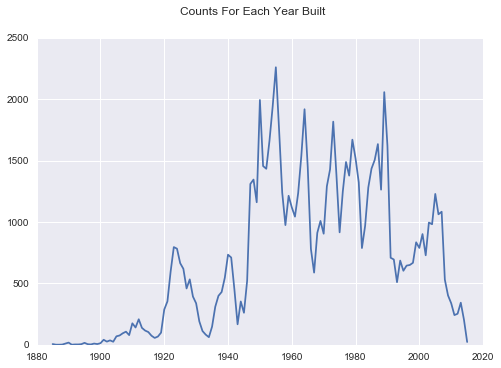

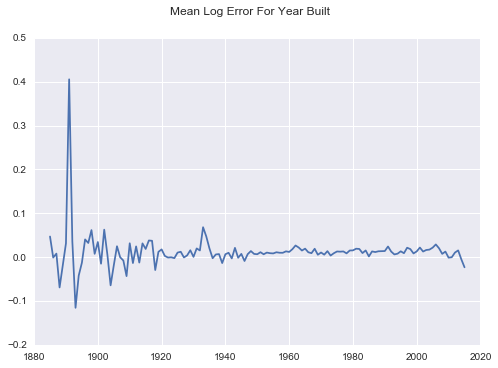

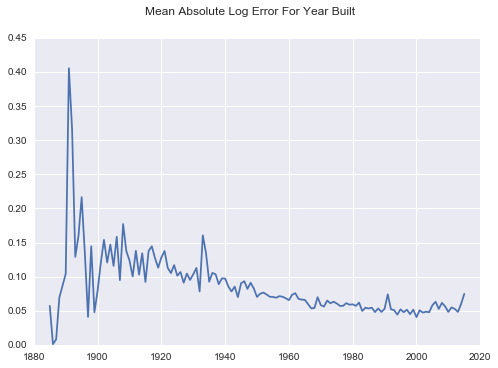

In [12]:
# Let's investigate diffusing the year built.

grouped_df = vals_df.groupby('yearbuilt').count()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.suptitle('Counts For Each Year Built')
plt.show()

grouped_df = vals_df.groupby('yearbuilt').mean()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.suptitle('Mean Log Error For Year Built')
plt.show()

plt.plot(grouped_df.index, grouped_df.abslogerror)
plt.suptitle('Mean Absolute Log Error For Year Built')
plt.show()

In [27]:
# Get a graph of smallest L1 norm for L1 linear fit of diffusion as func of num neighbors to use in diffusion.

niterations = 40     # Number of iterations to do gradient descent on L1 norm.
learningrate = 10**-6     # Scaling factor for gradient descent.

diffinit = vals_df.yearbuilt.values.T     # Initial values of diffusions
coords = vals_df[['latitude', 'longitude']].values    # Coords for diffusions
diffusions = np.zeros(diffinit.shape)     # Will hold the actual value of the diffusions.
        
errors = []    # For keeping track of errors.

ks = range(1, 10, 4)     # Different possibilities of numbers of neighbors.
epsilons = np.arange(10**3, 10**4, 2*10**3)   # Possible epsilons to use in average weighting.
nbrs = NearestNeighbors()
nbrs.fit(coords)

for k in ks:
    
    nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)
    
    for epsilon in epsilons:
        
        nbrdiffusions = diffinit[nbrindex]
        nbrdistance += epsilon
        nbrdistance = 1.0 / nbrdistance
        meandiffusions = nbrdistance * nbrdiffusions
        meandiffusions = np.sum(meandiffusions, axis = 1)
        meandiffusions /= np.sum(nbrdistance, axis = 1)
        newdiffusions = np.stack((meandiffusions, diffinit))
        diffusions = np.amax(newdiffusions, axis = 0)
    